In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv("fifa22.csv")
df.head()

,name,rank,gender,wage_eur,log_wage,position,nationality,club,league,preferred_foot,shooting,passing,dribbling,defending,attacking,skill,movement,power,mentality,goalkeeping
0,Lionel Andrés Messi Cuccittini,93,M,320000.0,12.676076,RW,Argentina,Paris Saint-Germain,French Ligue 1,Left,92.0,91.0,95.0,26.333333,85.8,94.0,90.2,77.8,73.833333,10.8
1,Lucia Roberta Tough Bronze,92,F,NaN,NaN,NaN,England,NaN,NaN,Right,61.0,70.0,81.0,89.000000,69.0,62.2,84.2,78.8,69.166667,12.6
2,Vivianne Miedema,92,F,NaN,NaN,NaN,Netherlands,NaN,NaN,Right,93.0,75.0,88.0,25.000000,86.0,79.0,80.6,84.0,70.833333,15.6
3,Wéndèleine Thérèse Renard,92,F,NaN,NaN,NaN,France,NaN,NaN,Right,70.0,62.0,73.0,91.333333,62.6,67.8,64.0,82.4,73.500000,12.8
4,Robert Lewandowski,92,M,270000.0,12.506177,ST,Poland,FC Bayern München,German 1. Bundesliga,Right,92.0,79.0,86.0,32.000000,86.0,81.4,81.6,84.8,80.666667,10.2


the unit of analysis appears to be an individual soccer players. 

In [4]:
observations, features = df.shape
print(f"Number of observations: {observations}")
print(f"Number of features: {features}")

Number of observations: 19630
Number of features: 20


There are 19,630 observations and 20 features in the dataset. 

In [6]:
df['gender'].value_counts()

gender
M    19239
F      391
Name: count, dtype: int64

There are 19,239 male players and 391 female players in the dataset. 

In [8]:
# drop only rows where the column passing contains a NaN for practice
df_dropped = df.dropna(subset=['passing'])

# display shape
df_dropped.shape

(17450, 20)

In [9]:
import statsmodels.api as sm

In [10]:
X = df[['passing', 'attacking', 'defending', 'skill']]
y = df['rank']
X = sm.add_constant(X)
model = sm.OLS(y, X, missing='drop').fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rank   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                 1.044e+04
Date:                Thu, 06 Feb 2025   Prob (F-statistic):               0.00
Time:                        01:42:36   Log-Likelihood:                -47856.
No. Observations:               17450   AIC:                         9.572e+04
Df Residuals:                   17445   BIC:                         9.576e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.3278      0.203    124.785      0.000      24.930      25.726
passing       -0.0247      0.010     -2.425      0.015      -0.045      -0.005
attacking      0.6109      0.006     94.005      0.000       0.598       0.624
defending      0.1719      0.002     84.413      0.000       0.168       0.176
skill          0.0066      0.009      0.730      0.465      -0.011       0.024
==============================================================================
Omnibus:                      171.799   Durbin-Watson:                   1.342
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              178.339
Skew:                           0.234   Prob(JB):                     1.88e-39
Kurtosis:                       3.163   Cond. No.                         790.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

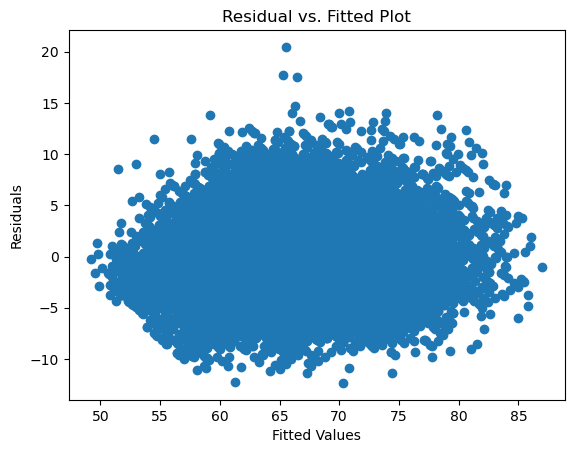

In [11]:
fitted_values = model.fittedvalues
residuals = model.resid

plt.scatter(fitted_values, residuals)
plt.title('Residual vs. Fitted Plot')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

After plotting residual-versus-fitted, you can see that heteroskedasticity is not a problem because the plot does not have a clear trend. 
One concern could be the outlier values that have residuals between the 15-20 range(roughly x=65). Since residual is the difference/error between the predicted and observed values, outliers with unusually large residuals could mean that the model's accuracy is inconsistent.

The variation in rank which is explained by our features is the R-squared statistic, which is 0.705. We can say that about 70.5% of the variation in rank is explained by the features in our model. 

Holding passing, attacking, and defending constant, a 1-unit increase in “skill” is associated with a .0066 increase in rank. I got this value by observing the coefficient associated with skill in the model summary. Notice still that the p-value for skill .465, meaning that it might not have a big influence here. 

A 95% confidence interval for the effect of a 1-unit increase in skill(holding passing, attacking, and defending constant) on ranking is [-0.011, 0.024], as seen in the model summary.

Since the 95% confidence interval for the effect of a 1-unit increase in skill (holding other features constant) on ranking is [-0.011, 0.024], we can glean several things. Firstly, if we were to repeatedly collect random samples from the population and calculate the confidence interval for the coefficient associated with the skill feature, then in 95% of those samples, the true coefficient would fall within the calculated confidence interval. Secondly, the 95% confidence interval contains zero, meaning that a 1-unit increase in skill (holding other features constant) could correspond to a negative effect, a positive effect, or no effect at all. This inclusion of zero suggests that the null hypothesis—that the coefficient of skill is zero—cannot be rejected.

Based on the OLS regression, we can expect that the four features (passing, attacking, defending, and skill) will do fairly well for predicting rank for out-of-sample data based on a few things. Firstly, the R-squared value is 0.705, meaning that 70.5% of the variance in the rank is explain by the four features previously mentioned. Secondly, if we choose an alpha level of .05, we can say that passing, attacking, and defending are statistically significant predictors of rank. However, skill has a p-value of 0.465, indicating it is not statistically significant. 

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
# Create an X dataframe with just four features: passing, attacking, defending, and skill
X = df[['passing', 'attacking', 'defending', 'skill']]
# Create a Y dataframe (or series) with just the “rank” variable
Y = df['rank']

In [20]:
# X first five rows
X.head()

,passing,attacking,defending,skill
0,91.0,85.8,26.333333,94.0
1,70.0,69.0,89.000000,62.2
2,75.0,86.0,25.000000,79.0
3,62.0,62.6,91.333333,67.8
4,79.0,86.0,32.000000,81.4


In [21]:
# Y first five rows
Y.head()

0    93
1    92
2    92
3    92
4    92
Name: rank, dtype: int64

In [22]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.25, random_state=123)
X_train.head()

,passing,attacking,defending,skill
3225,44.0,42.4,75.333333,39.4
18668,52.0,46.6,48.666667,50.6
9311,NaN,12.0,10.000000,14.2
19247,45.0,43.6,32.666667,43.6
11498,54.0,58.4,45.000000,54.4


In [23]:
from sklearn.linear_model import LinearRegression
X_train_clean = X_train.dropna()
Y_train_clean = Y_train.loc[X_train_clean.index]

# Train a linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train_clean, Y_train_clean)

# Get intercept and coefs
intercept = linear_model.intercept_
coefficients = linear_model.coef_

intercept, coefficients

(25.26043896525949,
 array([-0.02738345,  0.61570071,  0.17364093,  0.00464593]))

In [24]:
# Get difference between Attacking coefficients from both models
statsmodels_coef = 0.6109
sklearn_coef = coefficients[1]
print(f"Difference between Attacking coefficient: {statsmodels_coef - sklearn_coef}")

Difference between Attacking coefficient: -0.004800705533391181


The coefficients are pretty similar. In the OLS regression model, the coefficients were the following - Passing: -0.0247, Attacking: 0.6109, Defending: 0.1719, Skill: 0.0066. The linear regression (SKLearn) done in part has the following coefficients - Passing: -0.02738345, Attacking: 0.61570071, Defending: 0.17364093, Skill: 0.00464593. Notice that the "Attacking" coefficient decreased by roughly -0.004800 (as you can see above) from the statsmodels regression to the SKLearn one. 

In [26]:
# use linear_model to predict X validation set data
Y_val_predictions = linear_model.predict(X_val.dropna())

# Display the first three predicted values
Y_val_predictions[:3]

array([74.8589868, 64.3430183, 57.9340074])

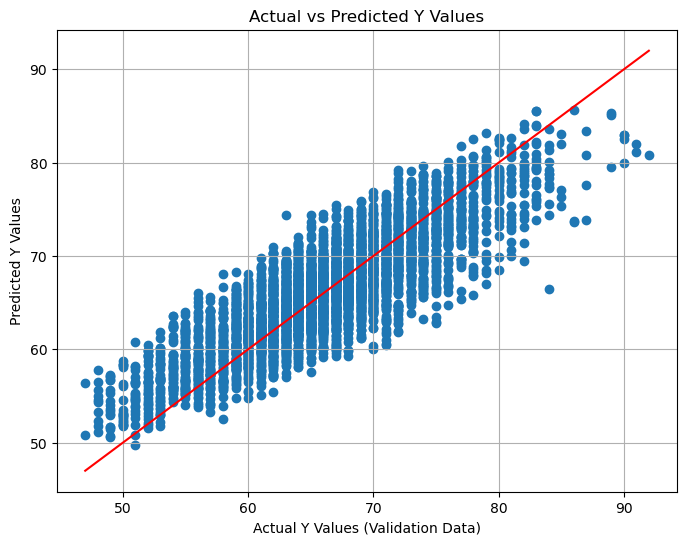

In [27]:
Y_val_clean = Y_val.loc[X_val.dropna().index]
# Scatterplot of actual vs predicted Y values
plt.figure(figsize=(8, 6))
plt.scatter(Y_val_clean, Y_val_predictions)
# Plot x = y to compare with observed vs. predicted
plt.plot([Y_val_clean.min(), Y_val_clean.max()], [Y_val_clean.min(), Y_val_clean.max()], color='red') 
plt.title("Actual vs Predicted Y Values")
plt.xlabel("Actual Y Values (Validation Data)")
plt.ylabel("Predicted Y Values")
plt.grid(True)
plt.show()

In [28]:
from sklearn.metrics import mean_squared_error
import numpy as np
rmse = np.sqrt(mean_squared_error(Y_val_clean, Y_val_predictions))
rmse

3.7308034318745116

As you can see by the calculation above, the Root Mean Squared Error is around 3.7308. This means that the average error across the model between the predicted Y-values and the actual observed Y-values is roughly 3.7308 units. Based on this, the model seems to provide fairly accurate predictions although there is still room for improvement. 

As mentioned above, I think this model provides fairly accurate predictions for player rank. The RMSE is around 3.7308, meaning that the average error between predicted Y-values and observed ones is approximately 3.7308 rank units. The scatterplot of predicted vs. observed Y-values shows that predictions generally align well with the x=y line, suggesting that the model captures the underlying pattern nicely. While there are some outliers, the model performs well overall in predicting player rank.

In [31]:
df['preferred_foot'].value_counts()

preferred_foot
Right    14985
Left      4645
Name: count, dtype: int64

In [32]:
right_foot_percentage = (df['preferred_foot'].value_counts()['Right'] / df.shape[0]) * 100
print(f"% of right-footed players: {round(right_foot_percentage, 2)}")

% of right-footed players: 76.34


In [33]:
X_classifier = df[['shooting', 'passing', 'dribbling', 'defending', 'attacking', 
                          'skill', 'movement', 'power', 'mentality', 'goalkeeping']]
X_classifier.head()

,shooting,passing,dribbling,defending,attacking,skill,movement,power,mentality,goalkeeping
0,92.0,91.0,95.0,26.333333,85.8,94.0,90.2,77.8,73.833333,10.8
1,61.0,70.0,81.0,89.000000,69.0,62.2,84.2,78.8,69.166667,12.6
2,93.0,75.0,88.0,25.000000,86.0,79.0,80.6,84.0,70.833333,15.6
3,70.0,62.0,73.0,91.333333,62.6,67.8,64.0,82.4,73.500000,12.8
4,92.0,79.0,86.0,32.000000,86.0,81.4,81.6,84.8,80.666667,10.2


In [34]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_classifier)
X_normalized_df = pd.DataFrame(X_normalized, columns=X_classifier.columns)

# Display first three rows of the normalized data
X_normalized_df.head()

,shooting,passing,dribbling,defending,attacking,skill,movement,power,mentality,goalkeeping
0,2.784312,3.296642,3.315358,-1.005167,2.386146,2.685046,2.313003,1.765803,1.721549,-0.320847
1,0.597719,1.229719,1.876719,2.051086,1.270271,0.676662,1.787188,1.862531,1.350906,-0.205781
2,2.854847,1.721843,2.596039,-1.070194,2.399430,1.737695,1.471698,2.365515,1.483279,-0.014003
3,1.232536,0.442320,1.054640,2.164883,0.845177,1.030340,0.016941,2.210750,1.695075,-0.192996
4,2.784312,2.115543,2.390519,-0.728804,2.399430,1.889271,1.559334,2.442897,2.264277,-0.359203


In [35]:
Y_classifier = df['preferred_foot']
X_train_classifier, X_val_classifier, Y_train_classifier, Y_val_classifier = train_test_split(
    X_normalized_df, Y_classifier, test_size=0.30, random_state=456)

# Display first 5 rows of X training data
X_train_classifier.head()

,shooting,passing,dribbling,defending,attacking,skill,movement,power,mentality,goalkeeping
18335,0.174507,-1.329328,-0.486758,-1.314044,-0.137855,-0.333846,-0.631565,-0.265478,-0.925901,-0.461484
15808,-0.389775,0.147045,-0.075718,0.344136,0.127829,0.272459,-0.053167,0.334233,0.080130,-0.371988
5295,-0.671916,0.343895,0.540841,1.059430,0.194250,0.310353,0.297376,0.643762,0.318401,-0.371988
10725,0.668254,0.147045,0.438081,0.116543,0.579492,0.487192,1.296426,0.276197,0.013944,-0.487054
6127,1.162001,0.737594,0.951880,-1.053937,1.137429,0.588242,1.086100,0.430961,0.172791,-0.269706


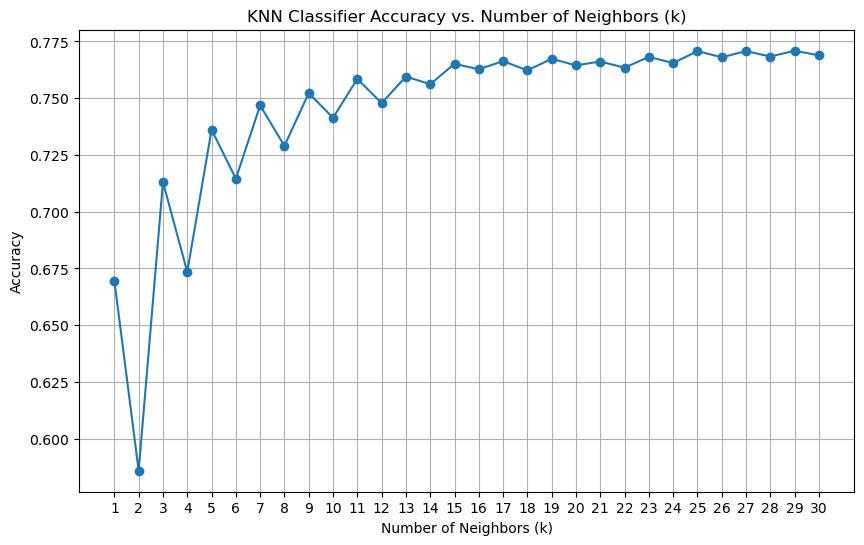

In [36]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Although maybe not entirely necessary, lets impute missing values rather than dropping rows that contain them. 
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train_classifier_imputed = imputer.fit_transform(X_train_classifier)
X_val_classifier_imputed = imputer.transform(X_val_classifier)
# Initialize list for k_values and accuracies - will append accuracies list later
k_values = list(range(1, 31))
accuracies = []
# for loop through list and calculate accuracy
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_classifier_imputed, Y_train_classifier)
    # Predict on the validation set
    Y_val_pred = knn.predict(X_val_classifier_imputed)
    accuracy = accuracy_score(Y_val_classifier, Y_val_pred)
    accuracies.append(accuracy)

# adjust figsize, if not x-axis numbers are squashed
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o')
plt.title('KNN Classifier Accuracy vs. Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [37]:
print(f"Best value for K: {k_values[accuracies.index(max(accuracies))]}")
print(f"Accuracy for K-value 29: {round(max(accuracies), 4)}")

Best value for K: 29
Accuracy for K-value 29: 0.7709


As you can see above, the most reasonable k-value is 29, because it has the highest accuracy with roughly .7709 when rounded to the nearest 4th decimal place. 

In [39]:
knn_final = KNeighborsClassifier(n_neighbors=29)
knn_final.fit(X_train_classifier_imputed, Y_train_classifier)
Y_val_final_pred = knn_final.predict(X_val_classifier_imputed)
# Display (at least) the first 3 predictions for “preferred foot.”
Y_val_final_pred[:3]

array(['Right', 'Right', 'Right'], dtype=object)

In [40]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(Y_val_classifier, Y_val_final_pred)
# Extract num for True Lefts predicted as Right
true_left_pred_right = conf_matrix[0, 1]
true_left_pred_right

1290

In [41]:
from sklearn.metrics import classification_report
class_report = classification_report(Y_val_classifier, Y_val_final_pred)
print(class_report)

              precision    recall  f1-score   support

        Left       0.51      0.05      0.08      1352
       Right       0.78      0.99      0.87      4537

    accuracy                           0.77      5889
   macro avg       0.64      0.52      0.48      5889
weighted avg       0.72      0.77      0.69      5889



The recall here (.05) suggests that the model only correctly identified 5% of the true left-footers in the dataset. One must always be careful when classes are very unbalanced. We previously saw that the soccer players in this study disproportionately skew to be right-footed, meaning our KNN model trained on this data set could be biased towards predicting right-footers. Notice how the recall for right-footed predictions is unbelievably high, around 99%. 

Overall, the model does a poor job of predicting a player's preferred foot. As we calculated early on, simply guessing that a player is right-footed each time would yield an accuracy of 76.34%, which is already quite high. After optimizing k for KNN, the model achieved only a marginal improvement, with an accuracy of 77.09%. While this may seem satisfactory at first, the recall for left-footers was shockingly low. The model predicts right-footers well, but this is largely because it guesses 'Right' most of the time due to the class imbalance. Accuracy alone is not a sufficient metric for evaluating models in the presence of unbalanced classes. The model's inability to predict left-footed players makes it inadequate for predicting a players preferred-foot.